# Trial of various feature selection algorithms


In [1]:
import os
from sys import stdout
import time

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
import scipy.io
from sklearn import model_selection
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV
from deap import base
from deap import creator
from deap import tools

from feature_selection import *




import warnings
warnings.filterwarnings('ignore')

In [2]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [3]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [4]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [5]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [6]:
def genetic_algorithm(X, y):

    autoscaled_X_train= X
    autoscaled_y_train=y



    # GAPLS
    creator.create('FitnessMax', base.Fitness, weights=(1.0,))  # for minimization, set weights as (-1.0,)
    creator.create('Individual', list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    min_boundary = np.zeros(X_train.shape[1])
    max_boundary = np.ones(X_train.shape[1]) * 1.0
    #print(min_boundary.shape)
    #print(max_boundary.shape)


    ###this one is for selecting at random the "individual"
    def create_ind_uniform(min_boundary, max_boundary):
        index = []
        for min, max in zip(min_boundary, max_boundary):
            index.append(random.uniform(min, max))
        return index


    toolbox.register('create_ind', create_ind_uniform, min_boundary, max_boundary)
    toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.create_ind)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)


    def evalOneMax(individual):
        individual_array = np.array(individual)
        #individual array is an array of lenght "wl" with values between 0 and 1. 
        #print("individual_array", individual_array.shape)

        selected_X_variable_numbers = np.where(individual_array > threshold_of_variable_selection)[0]
        #If an element of ind_arr is bigger than thresh it is kept. this one will be used for the selection of selected_autoscaled_X_train
        #print("selected_X_variable_numbers: ", selected_X_variable_numbers.shape)

        selected_autoscaled_X_train = autoscaled_X_train[:, selected_X_variable_numbers]
        #print("selected_autoscaled_X_train: ", selected_autoscaled_X_train.shape)


        if len(selected_X_variable_numbers):
            # cross-validation
            #print("np.linalg.matrix_rank(selected_autoscaled_X_train)", np.linalg.matrix_rank(selected_autoscaled_X_train))

            #print("AAAA ", min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1, max_number_of_components + 1))

            pls_components = np.arange(1, min(min(selected_autoscaled_X_train.shape[0],selected_autoscaled_X_train.shape[1]) + 1,
                                              max_number_of_components + 1), 1)
            #pls_components = np.arange(1, min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1,
            #                                  max_number_of_components + 1), 1)
            #print("pls components: ", pls_components)

            r2_cv_all = []

            for pls_component in pls_components:

                model_in_cv = PLSRegression(n_components=pls_component)

                #print("selected_autoscaled_X_train",selected_autoscaled_X_train)

                estimated_y_train_in_cv = np.ndarray.flatten(
                    model_selection.cross_val_predict(model_in_cv, selected_autoscaled_X_train, autoscaled_y_train, cv=fold_number))



                estimated_y_train_in_cv = estimated_y_train_in_cv * y_train.std(ddof=1) + y_train.mean()
                r2_cv_all.append(1 - sum((y_train - estimated_y_train_in_cv) ** 2) / sum((y_train - y_train.mean()) ** 2))
            #print(len(r2_cv_all))
            #print("r2_cv_all: ",r2_cv_all)
            """
            try:
                value = np.max(r2_cv_all)
            except ValueError:  #raised if `y` is empty.
                value = -999
                pass
            """
            value = np.max(r2_cv_all)

        else:
            value = -999

        return value,


    toolbox.register('evaluate', evalOneMax)
    toolbox.register('mate', tools.cxTwoPoint)
    toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
    toolbox.register('select', tools.selTournament, tournsize=3)

    # random.seed(100)
    random.seed()
    pop = toolbox.population(n=number_of_population)

    print('Start of evolution')

    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    print('  Evaluated %i individuals' % len(pop))

    for generation in range(number_of_generation):
        print('-- Generation {0} --'.format(generation + 1))

        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < probability_of_crossover:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < probability_of_mutation:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        print('  Evaluated %i individuals' % len(invalid_ind))

        pop[:] = offspring
        fits = [ind.fitness.values[0] for ind in pop]

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x * x for x in fits)
        std = abs(sum2 / length - mean ** 2) ** 0.5

        print('  Min %s' % min(fits))
        print('  Max %s' % max(fits))
        print('  Avg %s' % mean)
        print('  Std %s' % std)

    print('-- End of (successful) evolution --')

    best_individual = tools.selBest(pop, 1)[0]
    best_individual_array = np.array(best_individual)
    selected_X_variable_numbers = np.where(best_individual_array > threshold_of_variable_selection)[0]
    print('Selected variables : %s, %s' % (selected_X_variable_numbers, best_individual.fitness.values))

In [7]:
def _calculate_vips(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
    return vips

In [8]:
"""# Define the PLS regression object
pls = PLSRegression(n_components=8)
# Fit data
pls.fit(X_train, y_train)
# Plot spectra
plt.figure(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wl, X_train.T)
    plt.ylabel('First derivative absorbance spectra')
    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wl, np.abs(pls.coef_[:,0])) ###this is the interesting line!!!
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absolute value of PLS coefficients')
    plt.show()
"""

"# Define the PLS regression object\npls = PLSRegression(n_components=8)\n# Fit data\npls.fit(X_train, y_train)\n# Plot spectra\nplt.figure(figsize=(8,9))\nwith plt.style.context(('ggplot')):\n    ax1 = plt.subplot(211)\n    plt.plot(wl, X_train.T)\n    plt.ylabel('First derivative absorbance spectra')\n    ax2 = plt.subplot(212, sharex=ax1)\n    plt.plot(wl, np.abs(pls.coef_[:,0])) ###this is the interesting line!!!\n    plt.xlabel('Wavelength (nm)')\n    plt.ylabel('Absolute value of PLS coefficients')\n    plt.show()\n"

# Data loading

In [9]:
x_df = pd.read_csv('./avg_basic_noPure.csv', sep = ',')
x_df= x_df.drop(columns=['Measurement'])
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(31, 4094)
(4094,)
31


,188.195100,188.260100,188.325000,188.390000,188.455000,188.520000,188.585000,188.650000,188.714900,188.779900,...,440.300000,440.353000,440.406100,440.459200,440.512300,440.565300,440.618400,440.671400,440.724500,440.777500
0,-69.221869,-158.742833,-119.436366,-188.904643,-63.993252,-185.913809,-68.912441,-71.982774,-49.260124,-111.210412,...,57.987736,-58.837784,60.078744,-58.499735,50.963564,9.325138,48.628583,-25.978052,56.219128,-49.945180
1,-65.918565,-155.629829,-115.410786,-188.773574,-61.814280,-183.332260,-63.567206,-67.330086,-45.602930,-110.031973,...,57.015086,-44.614609,81.401937,-24.462199,86.909142,29.507515,56.597968,-23.360151,54.799998,-51.003948
2,-66.099613,-157.373422,-117.842186,-186.255659,-62.889293,-184.760538,-69.228256,-72.855963,-50.517550,-109.723183,...,51.295238,-38.257145,99.672488,7.856212,126.134965,58.828834,86.152177,28.781044,130.722225,34.606180
3,-64.677878,-154.233229,-115.096784,-184.164324,-59.970211,-183.733947,-66.853524,-70.610525,-48.705597,-106.973534,...,70.344273,6.833239,158.925279,89.783373,212.720167,104.908614,91.584860,1.405229,82.675708,-22.262239
4,-42.057358,-128.338506,-92.421250,-157.127160,-38.871675,-168.524296,-64.353986,-71.829442,-49.694992,-97.063802,...,65.735997,-15.182984,124.486568,38.564898,161.342291,74.535128,69.869111,-21.924734,55.972500,-55.878599
5,-42.559352,-128.806762,-93.862528,-160.944227,-40.074908,-167.939000,-62.026407,-67.816945,-46.463337,-97.883434,...,49.860573,-54.591599,67.895710,-44.346086,70.806932,15.151596,42.458800,-37.899700,43.898862,-65.108049
6,-46.600930,-131.936044,-96.007751,-163.920148,-40.905090,-172.729129,-64.568914,-70.719383,-50.106389,-98.386069,...,64.836896,-1.400873,148.828206,76.637705,211.221637,103.942782,89.391051,4.976541,89.927960,-13.085920
7,-44.351517,-128.386838,-94.080659,-159.433718,-39.895899,-169.744105,-65.728141,-72.196175,-51.243962,-97.024420,...,55.908894,-52.221276,68.591386,-42.618967,68.689610,19.444365,48.518350,-30.592518,51.197878,-59.143871
8,-42.553121,-129.333489,-93.232050,-157.068189,-39.735661,-170.282264,-66.426450,-72.554660,-52.577903,-97.059243,...,56.146984,-50.209511,74.266658,-35.492235,74.451395,23.316674,49.373189,-30.672551,51.549971,-62.015022
9,-41.323356,-128.644632,-92.694780,-157.775441,-38.448815,-169.676162,-63.930477,-69.095551,-48.203060,-95.684913,...,65.382647,0.046046,145.086180,67.958457,201.141755,99.619646,84.394483,-6.468004,73.146034,-35.164809


[[188.1951]
 [188.2601]
 [188.325 ]
 ...
 [440.6714]
 [440.7245]
 [440.7775]]


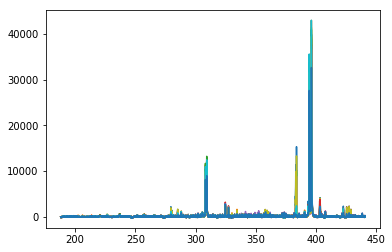

In [10]:
#This is just for visualizing the various plots of the samples


mat = scipy.io.loadmat("./data/001_11-Pech68451_200Hz_QS295_trig1435_int0.1.mat")
wl= mat["wl"]
print(wl)

for i in range(len(values)):
    plt.plot(wl, values[i])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""


In [11]:
df_y = pd.read_csv('./al_concentration_noPure.csv')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,1:-2])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(31, 14)


,Measurement,Reference material,Si,Fe,Mg,Ti,Ni,Zn,Cu,Mn,Pb,Sn,Cr,Al (100-summa)
0,1,Pech. 68451,0.070,0.100,0.4100,0.0400,0.0400,0.180,0.060,1.4500,0.0000,0.0000,0.0000,97.6
1,2,Gränges al 6958-v-335,0.180,0.350,2.0300,0.0600,0.0000,6.080,1.350,0.4500,0.0000,0.0000,0.1000,89.4
2,3,4343-AA,7.460,0.530,0.0360,0.0450,0.0310,0.140,0.150,0.1000,0.0000,0.0000,0.0000,91.4
3,4,NIST1256 (values for 1256b),9.362,0.865,0.0637,0.0868,0.4135,1.011,3.478,0.3857,0.1075,0.0091,0.0572,84.2
4,10,Pech. 1206,3.000,0.795,0.5700,0.0930,0.3010,0.154,4.290,0.0370,0.1000,0.2000,0.0000,90.5
5,11,Gränges al 6958-v-331,0.120,0.300,3.0400,0.0290,0.0000,4.930,1.850,0.0600,0.0000,0.0000,0.4000,89.3
6,12,NIST 1255a,7.220,0.140,0.3600,0.1540,0.0180,0.084,0.120,0.0530,0.0000,0.0000,0.0000,91.8
7,14,NBS 1258,0.780,0.079,0.9800,0.0000,0.0010,1.030,0.840,0.4800,0.0000,0.0000,0.0000,95.8
8,15,O 2:3,6.160,0.000,0.3630,0.0080,0.0000,0.000,0.006,0.2060,0.0000,0.0000,0.0000,93.3
9,16,NIST1256 (values for 1256b),9.362,0.865,0.0637,0.0868,0.4135,1.011,3.478,0.3857,0.1075,0.0091,0.0572,84.2


In [12]:
y_val = concentration[:,2] #2-Si, 3-Fe, 4-Mg, 8-Cu, 9-Mn (7-Zn but too much sparse)
print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
#y_df

[0.07 0.18 7.46 9.362 3.0 0.12 7.22 0.78 6.16 9.362 0.16 6.12 0.35 0.26
 8.75 9.362 0.53 0.36 0.18 0.18 9.362 12.53 9.5 0.16 9.46 8.565 0.185 9.14
 0.53 9.19 9.362]
(31,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state = 16)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(24, 4094) (24, 1)
(7, 4094) (7, 1)
        0
23   0.16
7    0.78
12   0.35
6    7.22
20  9.362
17   0.36
11   6.12


100% completed
Suggested number of components:  18



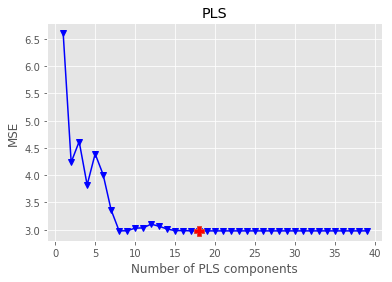

R2 calib: 1.000
R2 CV: 0.849
MSE calib: 0.000
MSE CV: 2.978


In [14]:
optimise_pls_cv(X_train, y_train, 40, plot_components=True) 

R2_pred:  0.7212877958043269
RMSE:  1.9284112468224002



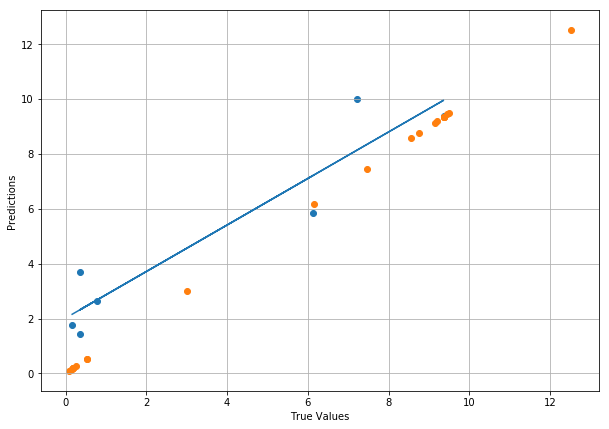

In [15]:
# Define PLS object
pls =  PLSRegression(n_components=18)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [16]:
wl=wl.astype('float32')

In [17]:
x_df.T

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
188.195100,-69.221869,-65.918565,-66.099613,-64.677878,-42.057358,-42.559352,-46.600930,-44.351517,-42.553121,-41.323356,...,-43.709099,-44.802595,-44.143214,-43.512278,-42.962442,-44.973295,-42.186507,-41.424810,-44.558939,-41.001750
188.260100,-158.742833,-155.629829,-157.373422,-154.233229,-128.338506,-128.806762,-131.936044,-128.386838,-129.333489,-128.644632,...,-130.799312,-131.679098,-130.700908,-130.211988,-130.615917,-129.786762,-128.244414,-128.706549,-131.794742,-126.887583
188.325000,-119.436366,-115.410786,-117.842186,-115.096784,-92.421250,-93.862528,-96.007751,-94.080659,-93.232050,-92.694780,...,-95.830795,-96.461123,-95.472576,-96.177873,-95.338675,-93.975872,-91.647544,-93.878258,-96.114594,-92.590419
188.390000,-188.904643,-188.773574,-186.255659,-184.164324,-157.127160,-160.944227,-163.920148,-159.433718,-157.068189,-157.775441,...,-160.807511,-161.389947,-161.864327,-160.883460,-160.608773,-158.000311,-158.000988,-158.244704,-161.053353,-157.707266
188.455000,-63.993252,-61.814280,-62.889293,-59.970211,-38.871675,-40.074908,-40.905090,-39.895899,-39.735661,-38.448815,...,-41.417551,-41.730097,-41.187290,-41.346391,-41.496645,-40.518737,-39.162065,-39.854569,-42.533650,-37.898732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440.565300,9.325138,29.507515,58.828834,104.908614,74.535128,15.151596,103.942782,19.444365,23.316674,99.619646,...,43.678281,38.577925,24.174772,137.393316,117.065611,26.203333,89.951912,5.926347,15.355934,121.621089
440.618400,48.628583,56.597968,86.152177,91.584860,69.869111,42.458800,89.391051,48.518350,49.373189,84.394483,...,62.424385,55.379554,48.139678,100.873342,90.030233,50.596162,79.712079,38.464411,48.055935,93.923003
440.671400,-25.978052,-23.360151,28.781044,1.405229,-21.924734,-37.899700,4.976541,-30.592518,-30.672551,-6.468004,...,-13.434274,-28.077536,-31.648690,-2.009867,-11.607915,-24.789738,-13.099729,-39.202001,-25.419803,-1.379237
440.724500,56.219128,54.799998,130.722225,82.675708,55.972500,43.898862,89.927960,51.197878,51.549971,73.146034,...,74.092781,48.952294,46.690674,69.786336,60.525301,59.956439,67.340693,42.676866,58.727192,80.649476


## MC-UVE feature selection

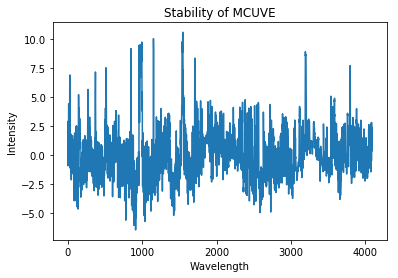

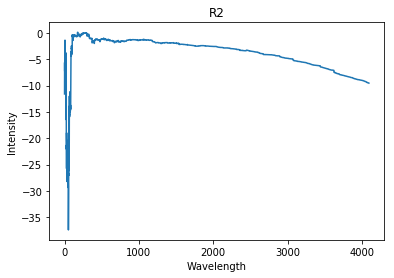

In [20]:
ncomp=20
X =x_df.values.astype('float32')
y=y_df.values.astype('float32')


# Stability of MC-UVE
mcModel = MCUVE(X, y, ncomp)
mcModel.calcCriteria()
plt.plot(mcModel.criteria)

plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Stability of MCUVE")
plt.show()

# Feature ranking efficienty by stability of MC-UVE
mcModel.evalCriteria(cv=10)
plt.plot(mcModel.featureR2)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("R2")
plt.show()

x_new = mcModel.cutFeature(X)[0]
x_selecta= pd.DataFrame(x_new)
print(x_selecta.shape)

(31, 177)
100% completed
Suggested number of components:  11



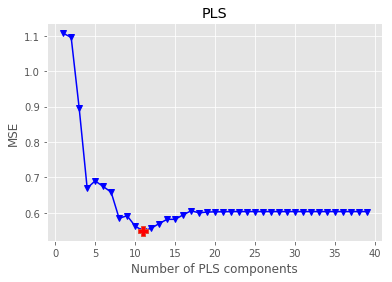

R2 calib: 1.000
R2 CV: 0.971
MSE calib: 0.009
MSE CV: 0.548


In [36]:
optimise_pls_cv(x_selecta, y_df, 40, plot_components=True) 

In [49]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)

R2_pred:  0.9739644173639485
RMSE:  0.8279380729619226



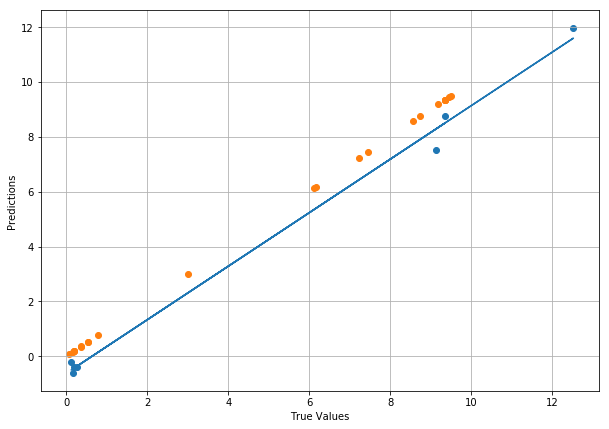

In [50]:
# Define PLS object
pls =  PLSRegression(n_components=ncomp)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## VC feature selection

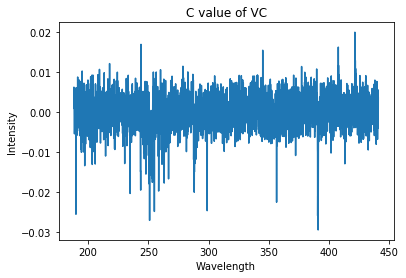

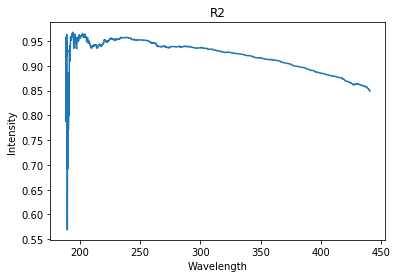

(31, 89)


In [51]:
ncomp=20
X =x_df.values.astype('float32')
y=y_df.values.astype('float32')


# C value of VC
vcModel = VC(X, y, ncomp, nrep=7000)
vcModel.calcCriteria()
plt.plot(wl, vcModel.criteria)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("C value of VC")
plt.show()

# Feature ranking efficienty by stability of VC
vcModel.evalCriteria(cv=5)
plt.plot(wl, vcModel.featureR2)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("R2")
plt.show()

# Prediction results after feature selection by VC
x_new = vcModel.cutFeature(X)[0]
x_selecta= pd.DataFrame(x_new)
print(x_selecta.shape)

100% completed
Suggested number of components:  5



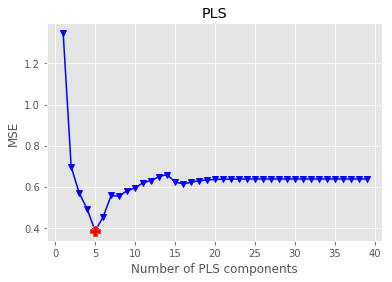

R2 calib: 0.994
R2 CV: 0.979
MSE calib: 0.113
MSE CV: 0.384


In [52]:
optimise_pls_cv(x_selecta, y_df, 40, plot_components=True) 

In [67]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)


R2_pred:  0.9687102872940643
RMSE:  0.6023268296130625



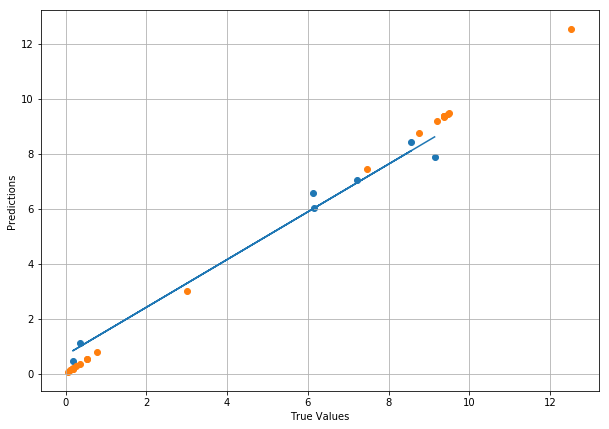

In [68]:
# Define PLS object
pls =  PLSRegression(n_components=ncomp)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# MSVC feature selection

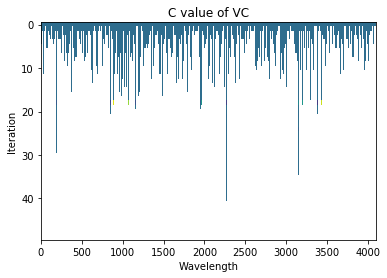

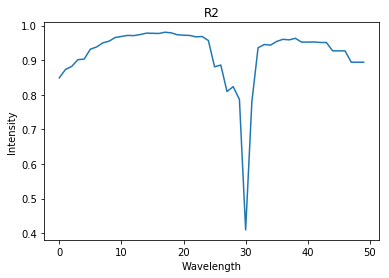

(31, 229)


In [72]:
ncomp=20
X =x_df.values.astype('float32')
y=y_df.values.astype('float32')

# C value of MSVC
vcModel = MSVC(X, y, ncomp, nrep=500)
vcModel.calcCriteria()
plt.imshow(vcModel.criteria, aspect='auto')
plt.xlabel("Wavelength")
plt.ylabel("Iteration")
plt.title("C value of VC")
plt.show()

# Feature ranking efficienty by stability of VC
vcModel.evalCriteria(cv=5)
plt.plot(vcModel.featureR2)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("R2")
plt.show()

# Prediction results after feature selection by VC
x_new = vcModel.cutFeature(X)[0]
x_selecta= pd.DataFrame(x_new)
print(x_selecta.shape)

100% completed
Suggested number of components:  11



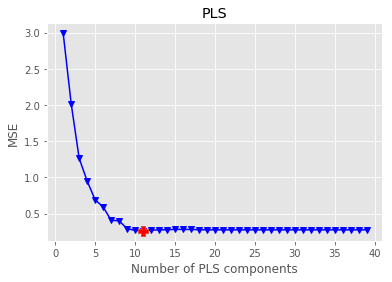

R2 calib: 1.000
R2 CV: 0.986
MSE calib: 0.007
MSE CV: 0.261


In [73]:
optimise_pls_cv(x_selecta, y_df, 40, plot_components=True) 

In [83]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)

R2_pred:  0.98036576200799
RMSE:  0.5437588753565613



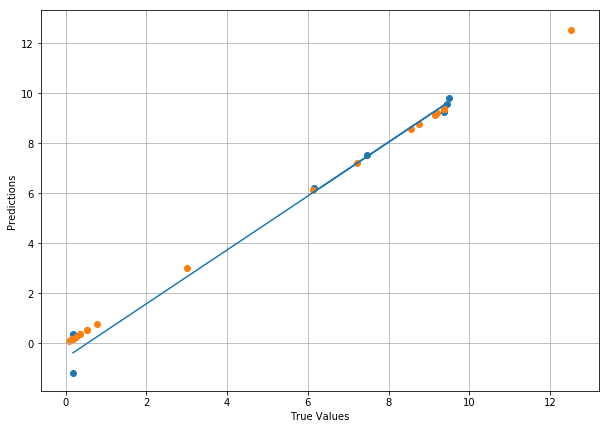

In [85]:
# Define PLS object
pls =  PLSRegression(n_components=ncomp)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

0.5108815909777921

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x_df, y_df, test_size=0.2, random_state = 13)
print(Ytest)

Xtrain=Xtrain.values.astype('float32')
Ytrain=Ytrain.values.astype('float32')
Xtest=Xtest.values.astype('float32')
Ytest=Ytest.values.astype('float32')

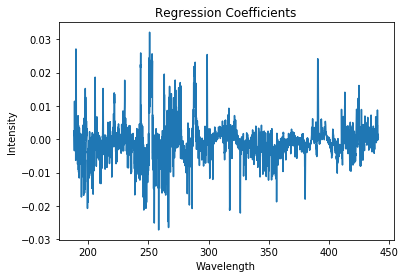

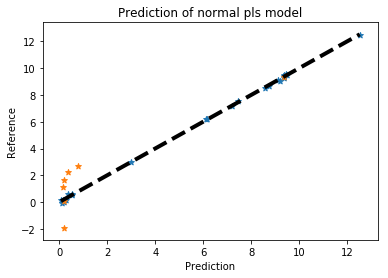

before feature selection
R2_pred:  0.7893912721802439
RMSE:  1.4571049438694204


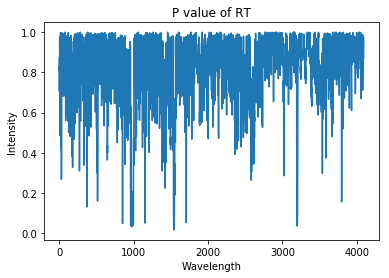

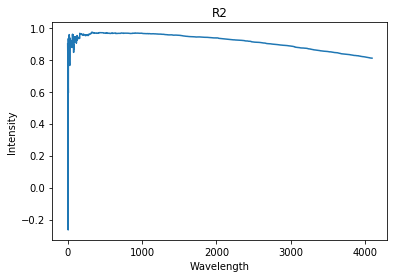

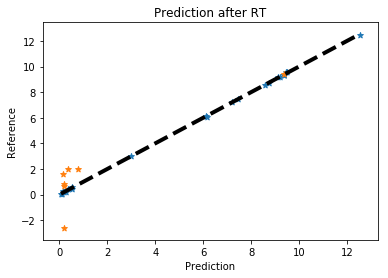

after feature selection
R2_pred:  0.7909471981837097
RMSE:  1.451712597792537


In [22]:
ncomp=10

plsModel = PLSRegression(n_components=ncomp)
plsModel.fit(Xtrain, Ytrain)
T, P, U, Q, W, C, beta = plsModel.x_scores_, plsModel.x_loadings_, plsModel.y_scores_, plsModel.y_loadings_, plsModel.x_weights_, plsModel.y_weights_, plsModel.coef_
plt.plot(wl, beta[0:])
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Regression Coefficients")
plt.savefig("./Image1_RegressionCoefficient_PLS.png")
plt.show()

# Prediction result of pls model
Ytrain_hat = plsModel.predict(Xtrain)
Ytest_hat = plsModel.predict(Xtest)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, Ytrain_hat, marker='*')
plt.scatter(Ytest, Ytest_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction of normal pls model")
plt.savefig("./Image2_PredictionPLS.png")
plt.show()

r2 = r2_score(Ytest, Ytest_hat)
rmse = sqrt(mean_squared_error(Ytest, Ytest_hat))
print("before feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)


# P value of RT
rtModel = RT(Xtrain, Ytrain, ncomp)
rtModel.calcCriteria()
plt.plot(rtModel.criteria)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("P value of RT")
plt.savefig("./Image3_P_vale.png")
plt.show()

# Feature ranking efficienty by stability of RT
rtModel.evalCriteria(cv=5)
plt.plot(rtModel.featureR2)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("R2")
plt.savefig("./Image4_R2.png")
plt.show()

# Prediction results after feature selection by RT
XtrainNew, XtestNew = rtModel.cutFeature(Xtrain, Xtest)
plsModelNew = PLSRegression(n_components=ncomp)
plsModelNew.fit(XtrainNew, Ytrain)
YtrainNew_hat = plsModelNew.predict(XtrainNew)
YtestNew_hat = plsModelNew.predict(XtestNew)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, YtrainNew_hat, marker='*')
plt.scatter(Ytest, YtestNew_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction after RT")
plt.savefig("./Image5_Prediction_RT.png")
plt.show()

r2 = r2_score(Ytest, YtestNew_hat)
rmse = sqrt(mean_squared_error(Ytest, YtestNew_hat))
print("after feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)

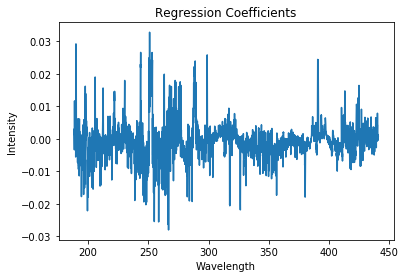

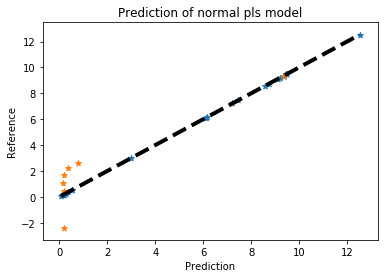

before feature selection
R2_pred:  0.7648993387003173
RMSE:  1.5394995797996531


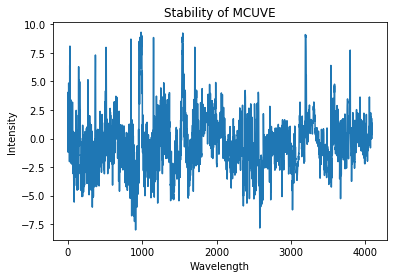

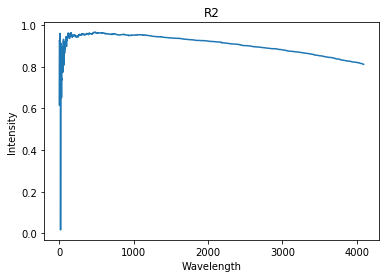

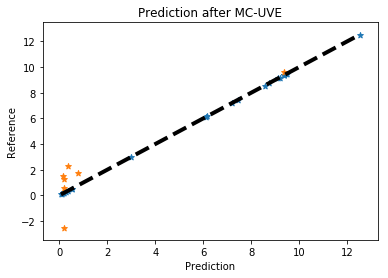

after feature selection
R2_pred:  0.7835349941754673
RMSE:  1.4772244869774245


In [23]:
ncomp=20

plsModel = PLSRegression(n_components=ncomp)
plsModel.fit(Xtrain, Ytrain)
T, P, U, Q, W, C, beta = plsModel.x_scores_, plsModel.x_loadings_, plsModel.y_scores_, plsModel.y_loadings_, plsModel.x_weights_, plsModel.y_weights_, plsModel.coef_
plt.plot(wl, beta[0:])
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Regression Coefficients")
plt.savefig("./Image1_RegressionCoefficient_PLS.png")
plt.show()

# Prediction result of pls model
Ytrain_hat = plsModel.predict(Xtrain)
Ytest_hat = plsModel.predict(Xtest)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, Ytrain_hat, marker='*')
plt.scatter(Ytest, Ytest_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction of normal pls model")
plt.savefig("./Image2_PredictionPLS.png")
plt.show()

r2 = r2_score(Ytest, Ytest_hat)
rmse = sqrt(mean_squared_error(Ytest, Ytest_hat))
print("before feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)


# Stability of MC-UVE
mcModel = MCUVE(Xtrain, Ytrain, ncomp)
mcModel.calcCriteria()
plt.plot(mcModel.criteria)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Stability of MCUVE")
plt.savefig("./Image3_Stability.png")
plt.show()

# Feature ranking efficienty by stability of MC-UVE
mcModel.evalCriteria(cv=5)
plt.plot(mcModel.featureR2)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("R2")
plt.savefig("./Image4_R2.png")
plt.show()

# Prediction results after feature selection by MC-UVE
XtrainNew, XtestNew = mcModel.cutFeature(Xtrain, Xtest)
plsModelNew = PLSRegression(n_components=ncomp)
plsModelNew.fit(XtrainNew, Ytrain)
YtrainNew_hat = plsModelNew.predict(XtrainNew)
YtestNew_hat = plsModelNew.predict(XtestNew)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, YtrainNew_hat, marker='*')
plt.scatter(Ytest, YtestNew_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction after MC-UVE")
plt.savefig("./Image5_Prediction_MC_UVE.png")
plt.show()

r2 = r2_score(Ytest, YtestNew_hat)
rmse = sqrt(mean_squared_error(Ytest, YtestNew_hat))
print("after feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)

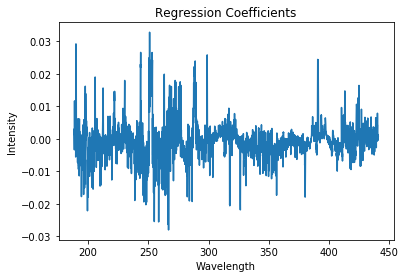

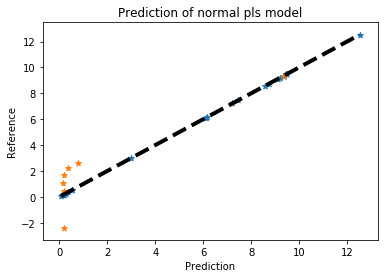

before feature selection
R2_pred:  0.7648993387003173
RMSE:  1.5394995797996531


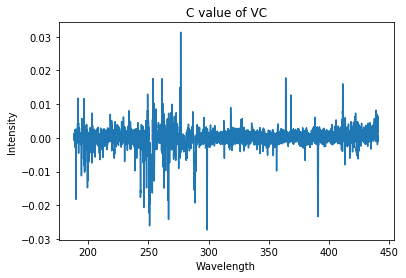

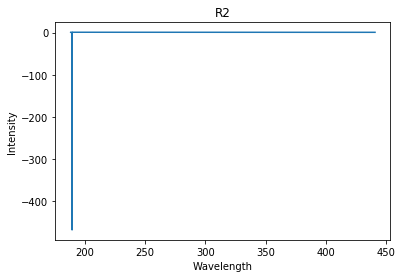

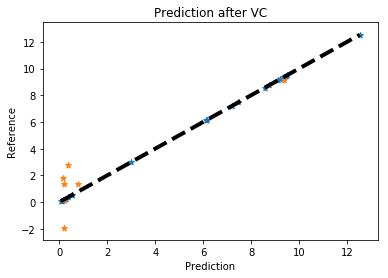

after feature selection
R2_pred:  0.7876026277607628
RMSE:  1.4632792664957124


In [24]:
ncomp=20

plsModel = PLSRegression(n_components=ncomp)
plsModel.fit(Xtrain, Ytrain)
T, P, U, Q, W, C, beta = plsModel.x_scores_, plsModel.x_loadings_, plsModel.y_scores_, plsModel.y_loadings_, plsModel.x_weights_, plsModel.y_weights_, plsModel.coef_
plt.plot(wl, beta[0:])
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Regression Coefficients")
plt.savefig("./Image1_RegressionCoefficient_PLS.png")
plt.show()

# Prediction result of pls model
Ytrain_hat = plsModel.predict(Xtrain)
Ytest_hat = plsModel.predict(Xtest)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, Ytrain_hat, marker='*')
plt.scatter(Ytest, Ytest_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction of normal pls model")
plt.savefig("./Image2_PredictionPLS.png")
plt.show()


r2 = r2_score(Ytest, Ytest_hat)
rmse = sqrt(mean_squared_error(Ytest, Ytest_hat))
print("before feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)



# C value of VC
vcModel = VC(Xtrain, Ytrain, ncomp, nrep=7000)
vcModel.calcCriteria()
plt.plot(wl, vcModel.criteria)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("C value of VC")
plt.savefig("./Image3_C_vale.png")
plt.show()

# Feature ranking efficienty by stability of VC
vcModel.evalCriteria(cv=5)
plt.plot(wl, vcModel.featureR2)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("R2")
plt.savefig("./Image4_R2.png")
plt.show()

# Prediction results after feature selection by VC
XtrainNew, XtestNew = vcModel.cutFeature(Xtrain, Xtest)

plsModelNew = PLSRegression(n_components=min([ncomp, rank(XtrainNew)]))
#plsModelNew = PLSRegression(n_components=ncomp)

plsModelNew.fit(XtrainNew, Ytrain)
YtrainNew_hat = plsModelNew.predict(XtrainNew)
YtestNew_hat = plsModelNew.predict(XtestNew)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, YtrainNew_hat, marker='*')
plt.scatter(Ytest, YtestNew_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction after VC")
plt.savefig("./Image5_Prediction_VC.png")
plt.show()

r2 = r2_score(Ytest, YtestNew_hat)
rmse = sqrt(mean_squared_error(Ytest, YtestNew_hat))
print("after feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)

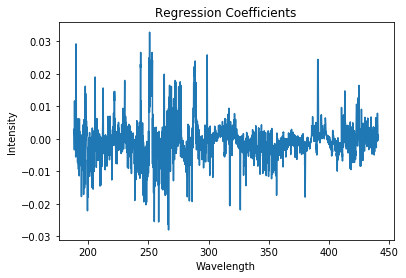

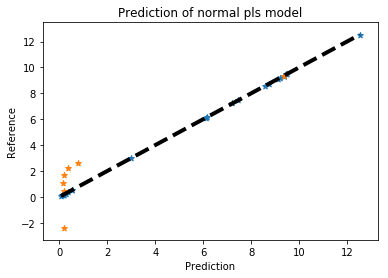

before feature selection
R2_pred:  0.7649017216897375
RMSE:  1.539491777566161


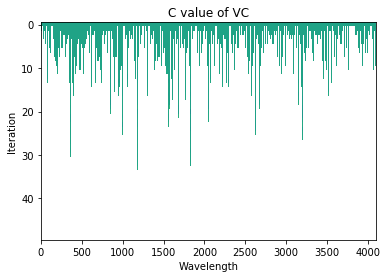

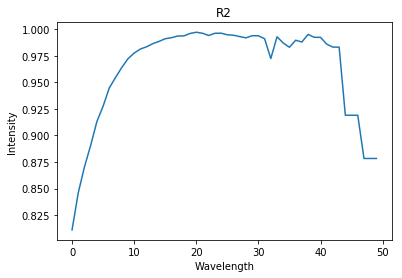

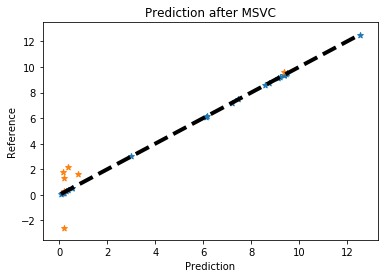

after feature selection
R2_pred:  0.7767742300313683
RMSE:  1.5001158996983837


In [25]:
ncomp=18

plsModel = PLSRegression(n_components=ncomp)
plsModel.fit(Xtrain, Ytrain)
T, P, U, Q, W, C, beta = plsModel.x_scores_, plsModel.x_loadings_, plsModel.y_scores_, plsModel.y_loadings_, plsModel.x_weights_, plsModel.y_weights_, plsModel.coef_
plt.plot(wl, beta[0:])
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Regression Coefficients")
plt.savefig("./Image1_RegressionCoefficient_PLS.png")
plt.show()

# Prediction result of pls model
Ytrain_hat = plsModel.predict(Xtrain)
Ytest_hat = plsModel.predict(Xtest)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, Ytrain_hat, marker='*')
plt.scatter(Ytest, Ytest_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction of normal pls model")
plt.savefig("./Image2_PredictionPLS.png")
plt.show()



r2 = r2_score(Ytest, Ytest_hat)
rmse = sqrt(mean_squared_error(Ytest, Ytest_hat))
print("before feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)



# C value of MSVC
vcModel = MSVC(Xtrain, Ytrain, ncomp, nrep=500)
vcModel.calcCriteria()
plt.imshow(vcModel.criteria, aspect='auto')
plt.xlabel("Wavelength")
plt.ylabel("Iteration")
plt.title("C value of VC")
plt.savefig("./Image3_MS_C_vale.png")
plt.show()

# Feature ranking efficienty by stability of VC
vcModel.evalCriteria(cv=5)
plt.plot(vcModel.featureR2)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("R2")
plt.savefig("./Image4_R2.png")
plt.show()

# Prediction results after feature selection by VC
XtrainNew, XtestNew = vcModel.cutFeature(Xtrain, Xtest)
plsModelNew = PLSRegression(n_components=min([ncomp, rank(XtrainNew)]))
plsModelNew.fit(XtrainNew, Ytrain)
YtrainNew_hat = plsModelNew.predict(XtrainNew)
YtestNew_hat = plsModelNew.predict(XtestNew)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, YtrainNew_hat, marker='*')
plt.scatter(Ytest, YtestNew_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction after MSVC")
plt.savefig("./Image5_Prediction_MSVC.png")
plt.show()


r2 = r2_score(Ytest, YtestNew_hat)
rmse = sqrt(mean_squared_error(Ytest, YtestNew_hat))
print("after feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)

In [28]:
XtrainNew.shape

(24, 137)

In [29]:
rank(XtrainNew)

24

In [31]:

X_train=XtrainNew
y_train=Ytrain
X_test=XtestNew
y_test=Ytest

R2_pred:  0.7767742300313683
RMSE:  1.5001158996983837



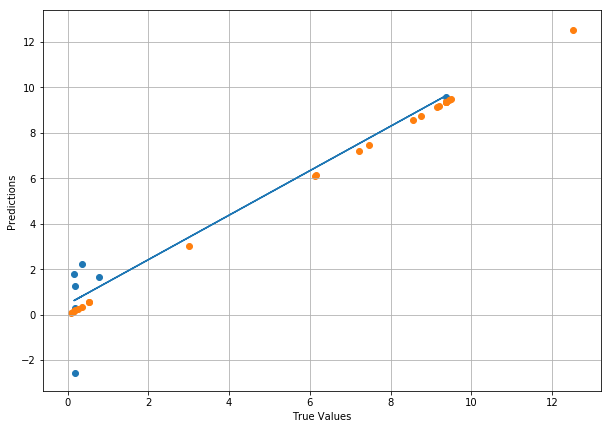

In [27]:
# Define PLS object
pls =  PLSRegression(n_components=18)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# VIP filter selection

In [159]:
a= _calculate_vips(pls)
print(a)
b=[]
for i in range(len(a)):
    if a[i]> 1.21:
        b.append(i)

x_selecta = pd.DataFrame(x_df.values[:,b])
print(x_selecta.shape)

[1.28229721 1.21217475 1.17745189 ... 1.45493084 1.17456334 1.23178447]
(24, 210)


37% completed
Suggested number of components:  5



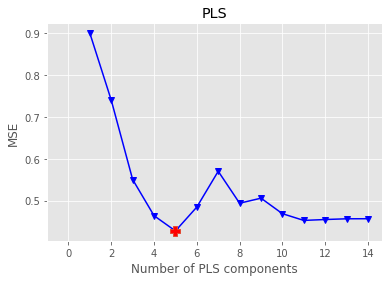

R2 calib: 0.962
R2 CV: 0.570
MSE calib: 0.038
MSE CV: 0.428


In [160]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)

optimise_pls_cv(X_train, y_train, 15, plot_components=True) 

R2_pred:  -0.3690216841795315
RMSE:  1.755614582771907



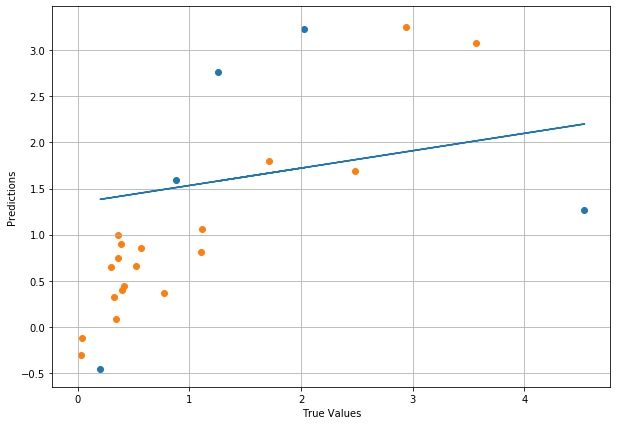

In [23]:
# Define PLS object
pls =  PLSRegression(n_components=3)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# wavelength selection with *i*-PLS 
NIRpy function

In [ ]:
start_time = time.time()
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_selecta.values, y_val, 15)
#opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)
print("--- %s seconds ---" % (time.time() - start_time))

print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

In [ ]:
optimise_pls_cv(X_train,y_train, 40, plot_components=True)

In [ ]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Genetic Algorithm with PLS

In [15]:
# GA settings
number_of_population = 200
number_of_generation = 100
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.01
threshold_of_variable_selection = 0.5

# input
X_train=values
y_train= y_val

#autoscaled_X_train= X_train
#autoscaled_y_train=y_train

autoscaled_X_train= (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
autoscaled_y_train = (y_train - y_train.mean()) / y_train.std(ddof=1)
#print(autoscaled_X_train.shape)
#print(autoscaled_y_train.shape)

#genetic_algorithm(autoscaled_X_train,autoscaled_y_train)

(34, 3648)
(34,)
33


In [25]:
x_selecta = pd.DataFrame(x_df.values[:,selected_X_variable_numbers])

In [103]:
#X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = 3) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(27, 348) (27, 1)
(7, 348) (7, 1)
       0
10  11.2
30  19.9
1     18
2   21.1
31    14
33  24.4
16   8.4


37% completed
Suggested number of components:  2



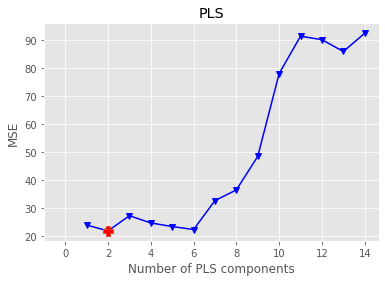

R2 calib: 0.349
R2 CV: 0.101
MSE calib: 15.815
MSE CV: 21.849


In [104]:
optimise_pls_cv(X_train, y_train, 15, plot_components=True) 

R2_pred:  -0.09441884308116721
RMSE:  1.4843109346366985



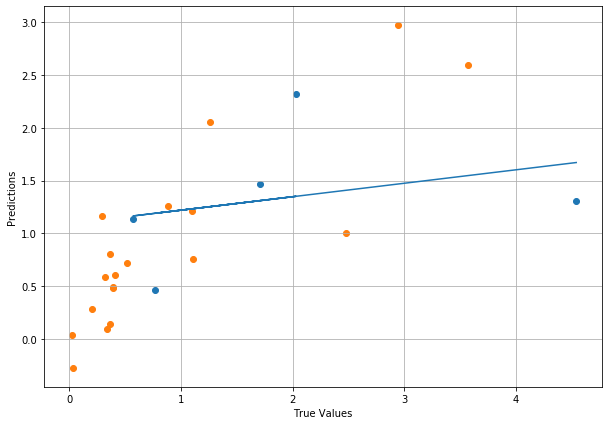

In [30]:
# Define PLS object
pls =  PLSRegression(n_components=3)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [25]:
start_time = time.time()

opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_selecta.values, y_val, 15)
#opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)

print("--- %s seconds ---" % (time.time() - start_time))

100% completed
Optimised number of PLS components:  12
Wavelengths to be discarded  177
Optimised MSEP  0.4391647684828197

--- 32.15109443664551 seconds ---


sorted wavelengths:  [271.5639 272.3414 262.0899 257.669  264.8179 271.9527 261.3101 264.1685
 265.0776 253.1133]


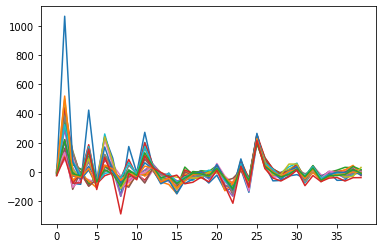

In [26]:
#print(opt_Xc.shape,"\n")
#print("sorted indexes: ", sorted_ind)
print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

In [44]:
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 39) (19, 1)
(5, 39) (5, 1)
        0
19  0.339
5   0.360
23  2.030
21  2.480
12  0.320


100% completed
Suggested number of components:  14



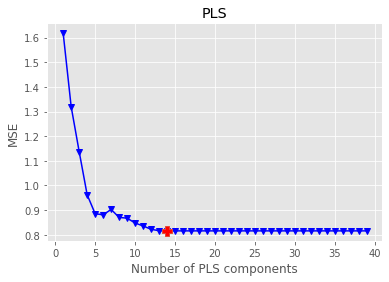

R2 calib: 1.000
R2 CV: 0.452
MSE calib: 0.000
MSE CV: 0.816


In [45]:
optimise_pls_cv(X_train,y_train, 40, plot_components=True)

R2_pred:  0.7360721453243093
RMSE:  0.4876059430361719



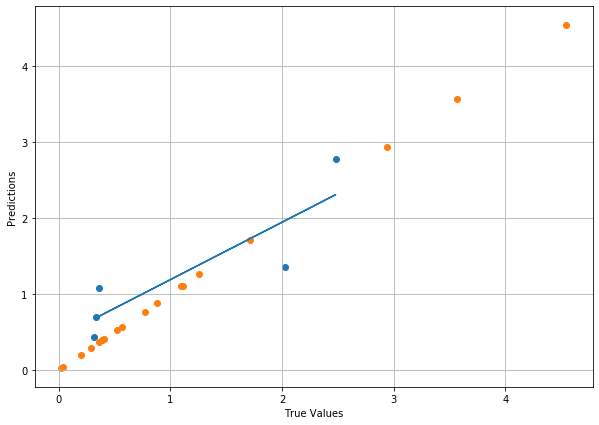

In [47]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

Best ones so far:

#1
number_of_population = 150
number_of_generation = 100
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.3
threshold_of_variable_selection = 0.6


#2
number_of_population = 150
number_of_generation = 100
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.25
threshold_of_variable_selection = 0.5


# Elastic Net

In [73]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:1.00, MSE:33.17, RMSE:5.76
Alpha:0.0010, R2:1.00, MSE:33.05, RMSE:5.75
Alpha:0.0100, R2:1.00, MSE:32.83, RMSE:5.73
Alpha:0.1000, R2:1.00, MSE:35.80, RMSE:5.98
Alpha:0.3000, R2:1.00, MSE:39.47, RMSE:6.28
Alpha:0.5000, R2:1.00, MSE:41.57, RMSE:6.45
Alpha:0.7000, R2:1.00, MSE:41.85, RMSE:6.47
Alpha:1.0000, R2:1.00, MSE:41.13, RMSE:6.41


In [74]:
model = ElasticNet(alpha=0.0001).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2: ", r2)

Train score:  0.9999768383309343
RMSE:  5.759070542511677
R^2:  -0.44802625066170787


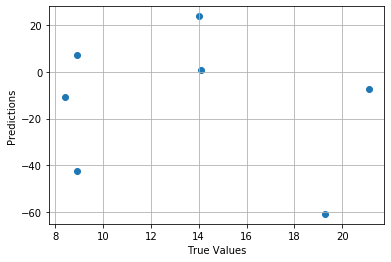

In [75]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [24]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.15)
X_train, X_test, y_train, y_test = train_test_split(principalComponents, y_df, test_size=0.15)


print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(y_test)

(20, 20) (20, 1)
(4, 20) (4, 1)


In [76]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(7,)
(27,)


RMSE:  3.2004078262978712
R^2:  0.5528200879619326 

[real, predictions]
[[14.1 15.032080000000029]
 [14.0 16.45600000000004]
 [8.9 9.520960000000006]
 [21.1 16.531200000000013]
 [8.4 8.7544]
 [8.9 15.052880000000046]
 [19.3 16.943200000000015]]


Text(0, 0.5, 'Predictions')

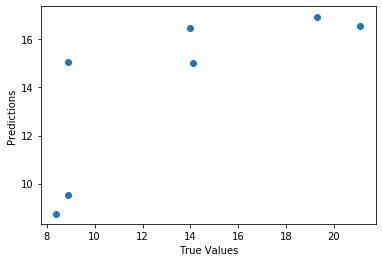

In [78]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 250, max_depth=30, random_state = 42)
# Train the model on training data

rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2, "\n")

y_test= y_test.reshape((len(y_test), 1))
predictions=predictions.reshape((len(y_test), 1))
#print((y_test, predictions))

b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# MultiOutput Random Forest

In [132]:
multi_y = concentration[:,1:-2]
print (multi_y.shape)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))

(24, 6)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [153]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1130) (19, 6)
(5, 1130) (5, 6)


In [134]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=650,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=650,
                                                

In [135]:
y_multirf = regr_multirf.predict(X_test)

In [136]:
print(y_test.shape)
print(y_multirf.shape)

(5, 6)
(5, 6)


In [137]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  -1.2798201186343863
RMSE:  1.5231794557929577


In [138]:
b=np.append(np.around(y_test,3), np.around(y_multirf,3), axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[6.160e+00 0.000e+00 3.630e-01 0.000e+00 6.000e-03 2.060e-01 8.711e+00
  2.880e-01 4.460e-01 2.870e-01 7.790e-01 1.910e-01]
 [6.120e+00 0.000e+00 3.200e-01 0.000e+00 5.000e-03 1.600e-02 8.009e+00
  2.150e-01 4.630e-01 8.500e-02 1.110e-01 1.440e-01]
 [1.253e+01 3.100e-01 2.500e-02 5.000e-02 5.600e-02 3.300e-02 7.822e+00
  2.570e-01 2.970e-01 1.650e-01 1.750e-01 2.170e-01]
 [1.800e-01 5.000e-01 1.110e+00 5.200e-02 1.500e-01 1.260e+00 4.830e-01
  3.630e-01 1.233e+00 2.260e-01 1.360e-01 9.710e-01]
 [1.290e+01 1.200e-01 5.200e-01 1.550e-01 5.200e-01 2.860e-01 6.898e+00
  3.360e-01 7.140e-01 1.420e-01 5.610e-01 2.290e-01]]


Text(0, 0.5, 'Predictions')

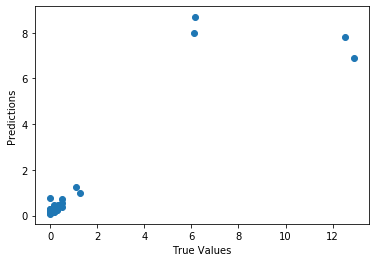

In [139]:
plt.scatter(y_test, y_multirf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [141]:
y_pred=np.around(y_multirf,2)
y_pred[:,0]

array([8.71, 8.01, 7.82, 0.48, 6.9 ])

In [142]:
y_test[0].values

array([ 6.16,  6.12, 12.53,  0.18, 12.9 ])

In [143]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [ 6.16  6.12 12.53  0.18 12.9 ]
pred:  [8.71 8.01 7.82 0.48 6.9 ]


# PLS-2

100% completed
Suggested number of components:  33



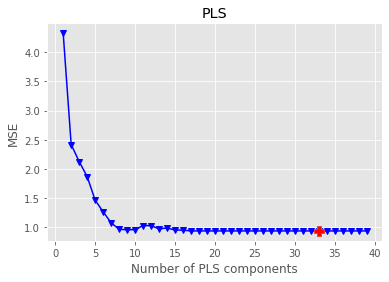

R2 calib: 1.000
R2 CV: 0.018
MSE calib: 0.000
MSE CV: 0.939


In [154]:
optimise_pls_cv(X_train, y_train, 40, plot_components=True)

In [155]:
# Define PLS object
pls = PLSRegression(n_components= 26)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R^2: ", score)
print("MSE: ", mse)

R^2:  0.018347253779067135
MSE:  0.9391318844120397


In [150]:
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print(score_pred) #NAMMERDA
print(score_cv)

-4.070272705754876
0.36555579763038115


In [151]:
pd.DataFrame(np.round(y_pred, decimals=2))

,0,1,2,3,4,5
0,7.84,0.22,0.54,0.19,0.57,0.27
1,8.62,0.12,0.35,0.06,-0.12,-0.06
2,10.50,0.13,-0.61,0.45,0.15,-0.03
3,-0.28,0.42,1.56,-0.11,-0.34,0.95
4,9.93,0.09,0.29,-0.26,0.65,0.14


In [152]:
np.round(y_test, decimals=2)

,0,1,2,3,4,5
20,6.16,0.00,0.36,0.00,0.01,0.21
12,6.12,0.00,0.32,0.00,0.01,0.02
13,12.53,0.31,0.02,0.05,0.06,0.03
22,0.18,0.50,1.11,0.05,0.15,1.26
7,12.90,0.12,0.52,0.16,0.52,0.29
